In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

C:\Users\edfra\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
### Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

### Create a list of tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [3]:
### Download the daily adjusted close prices for the tickers
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-10-14   74.726959  47.714626   82.199997   29.400589   37.386951
2008-10-15   67.370262  47.423683   83.309998   26.767569   33.890163
2008-10-16   70.176743  47.417213   79.290001   28.219673   35.450153
2008-10-17   69.757607  47.675827   77.209999   28.254658   35.118557
2008-10-20   73.948624  47.656464   78.500000   29.041939   36.919704
...                ...        ...         ...         ...         ...
2023-10-04  424.660004  69.000000  169.139999  359.750000  210.559998
2023-10-05  424.500000  6

In [4]:
### Calculate the daily log returns and drop any NAs
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2008-10-15 -0.103637 -0.006116  0.013413 -0.093824 -0.098197
2008-10-16  0.040813 -0.000136 -0.049457  0.052828  0.045003
2008-10-17 -0.005990  0.005439 -0.026583  0.001239 -0.009398
2008-10-20  0.058344 -0.000406  0.016570  0.027483  0.050016
2008-10-21 -0.030310  0.016949 -0.031971 -0.053198 -0.030676
...              ...       ...       ...       ...       ...
2023-10-04  0.007256  0.006543 -0.000118  0.013517  0.007197
2023-10-05 -0.000377  0.000724 -0.001834 -0.002951 -0.000523
2023-10-06  0.011803 -0.003918  0.005140  0.016617  0.011856
2023-10-09  0.006382  0.010126  0.018218  0.005087  0.006273
2023-10-10  0.005191 -0.001008 -0.001680  0.005523  0.006187

[3772 rows x 5 columns]


In [5]:
### Create a function that will be used to calculate portfolio expected return *We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [6]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

          SPY           BND       GLD           QQQ       VTI
SPY  0.000154 -1.613981e-06  0.000011  1.604535e-04  0.000156
BND -0.000002  9.457163e-06  0.000008 -9.784188e-07 -0.000001
GLD  0.000011  8.308013e-06  0.000109  1.044705e-05  0.000011
QQQ  0.000160 -9.784188e-07  0.000010  1.937958e-04  0.000163
VTI  0.000156 -1.490096e-06  0.000011  1.629983e-04  0.000159


In [7]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
#weights = np.array([0.1, 0.15, 0.20, 0.25, 0.30])
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [8]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

#This function incorporates volatility
def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [9]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [10]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

76843.8967340014


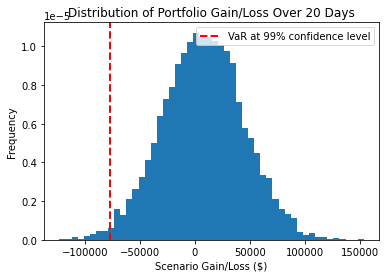

In [11]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()